In [1]:
%matplotlib inline

In [2]:
from collections import namedtuple
import os

import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf

import nengo
import nengo_dl
import nengo_loihi
#from nengo_loihi.inputs import DVSFileChipNode  # branch: dvs-file

from pytry.read import text

import davis_tracking
print(davis_tracking.__file__)

/home/arvoelke/.conda/envs/nx085/lib/python3.5/site-packages/nengo_dl/version.py:32: UserWarning: This version of `nengo_dl` has not been tested with your `nengo` version (3.0.0.dev0). The latest fully supported version is 2.8.0.
  ((nengo.version.version,) + latest_nengo_version))


/home/arvoelke/git/davis_tracking/davis_tracking/__init__.py


In [3]:
# model file generated via:
# repo: https://github.com/tcstewar/davis_tracking/ 
# commit: c712fac42bbf798107502dc5c4ef004b30e12782
#   pytry track_deep_heat.py --n_epochs=200 --n_data=-1 --test_set=one --save_params=True --seed=0

trained = os.path.abspath("data/TrackingTrial#20190618-162329-1d221ee6")
pdict = text("%s.txt" % trained)
p = namedtuple("Params", pdict.keys())(*pdict.values())
params = np.load("%s.params.npy" % trained, allow_pickle=True)

In [4]:
testfile = '../dataset/retinaTest95.events'

dt = 0.001
times, images, targets = davis_tracking.load_data(
    testfile,
    dt=dt,
    decay_time=0.005,  # p.decay_time
    separate_channels=p.separate_channels,
    saturation=p.saturation,
    merge=p.merge)

times.shape, images.shape, targets.shape

((1570,), (1570, 72, 48), (1570, 4))

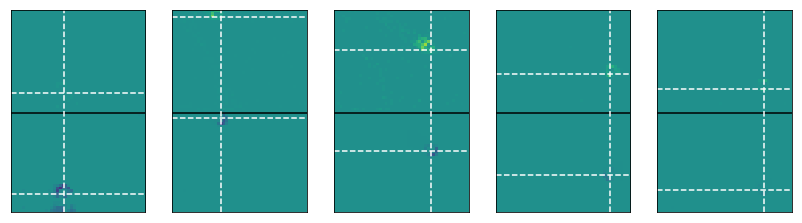

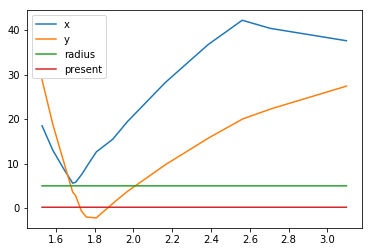

In [5]:
N = 5
plt.figure(figsize=(14,8))
indices = np.linspace(0, len(times)-1, N).astype(int)
for i, index in enumerate(indices):
    plt.subplot(1, N, i+1)
    plt.imshow(images[index], vmin=-1, vmax=1)
    plt.xticks([])
    plt.yticks([])
    plt.axhline(targets[index,1], c='w', ls='--')
    plt.axhline(images.shape[1]//2, c='k')
    plt.axhline(targets[index,1]+images.shape[1]//2, c='w', ls='--')
    plt.axvline(targets[index,0], c='w', ls='--')

plt.figure()
plt.plot(times, targets)
plt.legend(['x', 'y', 'radius', 'present'])

plt.show()

In [6]:
# copied over from track_deep_heat.py:
strip_edges = 3  #  the number of edge pixels to remove due to convolution
assert p.separate_channels
shape = (2, 180//p.merge, 240//p.merge)
output_shape = shape[1]-strip_edges*2, shape[2]-strip_edges*2

In [7]:
# count = np.searchsorted(t[event_index:], now + dt)
# s = slice(event_index, event_index+count)

# dts = dt-(t[s]-now)
# np.add.at(image, [y[s], x[s]], p[s]

In [8]:
t_start = times[0]

dimensions = shape[0]*shape[1]*shape[2]

with nengo.Network() as model:
    #inp = DVSFileChipNode(filename=datafile, t_start=t_start, pool=(p.merge, p.merge))
    #inp = nengo.Node(output=np.zeros(dimensions))
    inp = nengo.Node(output=nengo.processes.PresentInput(
        images.reshape(images.shape[0], -1), dt))
    
    out = nengo.Node(None, size_in=np.prod(output_shape))
    
    convnet = davis_tracking.ConvNet(nengo.Network())
    
    convnet.input = inp
    
    convnet.make_input_layer(
            shape,
            spatial_stride=(p.spatial_stride, p.spatial_stride), 
            spatial_size=(p.spatial_size, p.spatial_size))
    
    #nengo.Connection(inp, convnet.input)
    
    init = params[2]['transform'].init #if params is not None else nengo.dists.Uniform(-1, 1)
    convnet.make_middle_layer(n_features=p.n_features_1, n_parallel=p.n_parallel, n_local=1,
                              kernel_stride=(1,1), kernel_size=(3,3), init=init)
    init = params[3]['transform'].init #if params is not None else nengo.dists.Uniform(-1, 1)
    convnet.make_middle_layer(n_features=p.n_features_2, n_parallel=p.n_parallel, n_local=1,
                              kernel_stride=(1,1), kernel_size=(3,3), init=init)
    init = params[4]['transform'].init #if params is not None else nengo.dists.Uniform(-1, 1)
    convnet.make_middle_layer(n_features=1, n_parallel=p.n_parallel, n_local=1,
                              kernel_stride=(1,1), kernel_size=(3,3), init=init, use_neurons=False)
    convnet.make_merged_output(output_shape)
    nengo.Connection(convnet.output, out)
    
    p_out = nengo.Probe(out, synapse=None)

    if params is not None:
        assert np.allclose(params[0]['gain'], 100, atol=1e-5)
        assert np.allclose(params[1]['gain'], 100, atol=1e-5)
        if np.max(np.abs(params[0]['bias'])) > 1e-8:
            print('WARNING: biases are not yet being set on the neurons')
        if np.max(np.abs(params[1]['bias'])) > 1e-8:
            print('WARNING: biases are not yet being set on the neurons')

In [9]:
convert_to_spiking = True
add_synapses = 0.01

print("====================")

if convert_to_spiking:
    n_ensembles = 0
    for ens in model.all_ensembles:
        if isinstance(ens.neuron_type, nengo.RectifiedLinear):
            n_ensembles += 1
            ens.neuron_type = nengo.SpikingRectifiedLinear(
                amplitude=ens.neuron_type.amplitude)
    print("Changed %d ensembles" % n_ensembles)
    
if add_synapses is not None:    
    n_synapses = 0
    for conn in model.all_connections:
        n_synapses += 1
        conn.synapse = add_synapses
    print("Changed %d synapses" % n_synapses)

print("====================")

Changed 70 ensembles
Changed 141 synapses


In [10]:
with nengo.Simulator(model, dt=dt) as sim:
    sim.run(1.5)

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

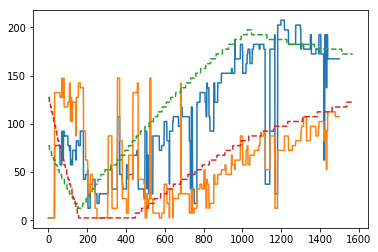

In [11]:
data = sim.data[p_out]  # [:len(targets_test)]

targets_heatmap = davis_tracking.make_heatmap(
    targets, merge=p.merge, strip_edges=strip_edges).reshape(len(targets), -1)

data_peak = np.array([davis_tracking.find_peak(img.reshape(output_shape)) for img in data])
target_peak = np.array([davis_tracking.find_peak(img.reshape(output_shape)) for img in targets_heatmap])

#rmse_test = np.sqrt(np.mean((target_peak-data_peak)**2, axis=0))*p.merge          
if plt:
    plt.plot(data_peak*p.merge)
    plt.plot(target_peak*p.merge, ls='--')
    #plt.plot((targets-strip_edges)*p.merge, ls=':')